#### Installation

In [1]:
!pip install openslide-python
# https://openslide.org/download/ binary downloaded


[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Import

In [2]:
import os

# openslide binaries
openslide_path = r"C:\D\openslide\bin"

# add to system path variable
os.environ['PATH'] = openslide_path + ";" + os.environ['PATH']

# Import the openslide module
import openslide
from openslide import OpenSlide

# import supporting modules
import numpy as np
import matplotlib.pyplot as plt

#### Download 4 WSI (random)

In [3]:
images = ['./images/Image1.svs', './images/Image2.svs', './images/Image3.svs', './images/Image4.svs']

#### 1) Reading WSI images using OpenSlide python library.

In [4]:
print("\t-----Dimensions-----")
wsi_images = []
for image in images:
    wsi_image = openslide.OpenSlide(image)
    print(image , " : " ,  wsi_image.dimensions)
    wsi_images.append(wsi_image)

	-----Dimensions-----
./images/Image1.svs  :  (39168, 96512)
./images/Image2.svs  :  (31655, 25773)
./images/Image3.svs  :  (77698, 65204)
./images/Image4.svs  :  (118946, 33588)


#### Image Processing

In [5]:
class ImageProcessing:
    
        def __init__(self, image, mpp, patch_size): 

            # initial class variables
            self.image = openslide.OpenSlide(image)
            self.x = self.image.dimensions[0]
            self.y = self.image.dimensions[1]
            self.patch_size = patch_size
            self.mpp = mpp

        def optimal_level(self): 
       
            # optimal level
            self.level = self.image.get_best_level_for_downsample(self.mpp)

        def extract(self):
            
            # 2.a : Maintain a suitable data structure
            
            # extract regions w.r.t. patch size
            self.regions = []
            self.patch_information = [] 
            for r in range(self.x):
                for c in range(self.y):
                    self.regions.append(self.image.read_region((c * self.patch_size[0], r * self.patch_size[1]), self.level, (self.patch_size[0], self.patch_size[1])))
                    self.patch_information.append({'x1': c * self.patch_size[0], 'y1': r * self.patch_size[1], 'w': self.patch_size[0], 'h': self.patch_size[1]})

            return self.regions, self.patch_information

        def linear_indexing(self):

            # 2.b : linear indexing of all patches

            info = list(self.patch_information.values())
            self.α = info[1] * info[2] + info[0]
            return self.α
        
        def extract_patch_xy(self, x, y):  

            # extract a patch given cordinates(x, y)
            patch = self.image.read_region((x, y), self.level, self.patch_size)
            patch = np.asarray(patch.convert('RGB'))
            return patch

        def extract_patch_linear_index(self, index):  

            # extract a patch given linear index
            x, y = linear_index_to_coordinates(index)
            return extract_patch_xy(x, y)

        def coordinates_to_linear_index(self, x, y):

            # 2.c : coordinates to linear index (column-wise)
            return self.x * y + x

        def linear_index_to_coordinates(self, index): 

            # 2.d : linear index to coordinates (column-wise)
            x_axis = index % self.x
            y_axis = (x_axis - index) // self.x
            return x_axis , y_axis

        def display_patch(self, x, y):

            # width & height
            w = self.patch_size[0]
            h = self.patch_size[1]
            
            # 8 neighbors
            neighbors = self.eight_neighbors_coordinates(x, y, w, h)
            
            # set plots
            fig, ax = plt.subplots(3, 3, figsize=(11,11))
            
            # plot names
            neighbor_name = ["Top Left", "Top Mid", "Top Right", "Left", "Main", 
                          "Right", "Bottom Left", "Bottom Mid", "Bottom Right"]
            
            for neighbor in neighbors:
                # extract neighbor dimension
                neighbor_number, x, y = neighbor
                # extract neighbor
                patch = self.extract_patch_xy(x, y)
                
                # plot neghbor
                ax[neighbor_number//3, neighbor_number % 3].imshow(patch)
                ax[neighbor_number//3, neighbor_number % 3].set_title(f'Neighbor : {neighbor_name[neighbor_number]}')
            plt.show()

        def eight_neighbors_coordinates(self, x, y, w, h): 

            # 3: generate list of all 8-neibouring patches of a given patch
            possible_combinations = [(x-w, y-h), (x, y-h), (x+w, y-h), 
                                     (x-w, y),   (x, y),   (x+w, y), 
                                     (x-w, y+h), (x, y+h), (x+w, y+h)]
            actual_neighbors = []

            # check neighbor eligibility
            for i, v in enumerate(possible_combinations):

                if v[0] >= 0:
                    if v[1] >= 0:
                        if (v[0] + w) <= self.x:
                            if (v[1] + h) <= self.y:
                                actual_neighbors.append([i, v[0], v[1]])

            return actual_neighbors

        def display_neighbors_coordinates(self, x, y): 

            # 2.e.i : display subplot of 8-neighbouring image patches, α, (x,y) of patch.
            self.display_patch(x, y)

        def display_neighbors_linear_index(self, linear_index): 

            # coordinates(x, y) to linear indexing 
            x, y = self.linear_index_to_coordinates(linear_index)
            # 2.e.ii : display subplot of 8-neighbouring image patches, α, (x,y) of patch.
            self.display_patch(x, y)

#### Image 2

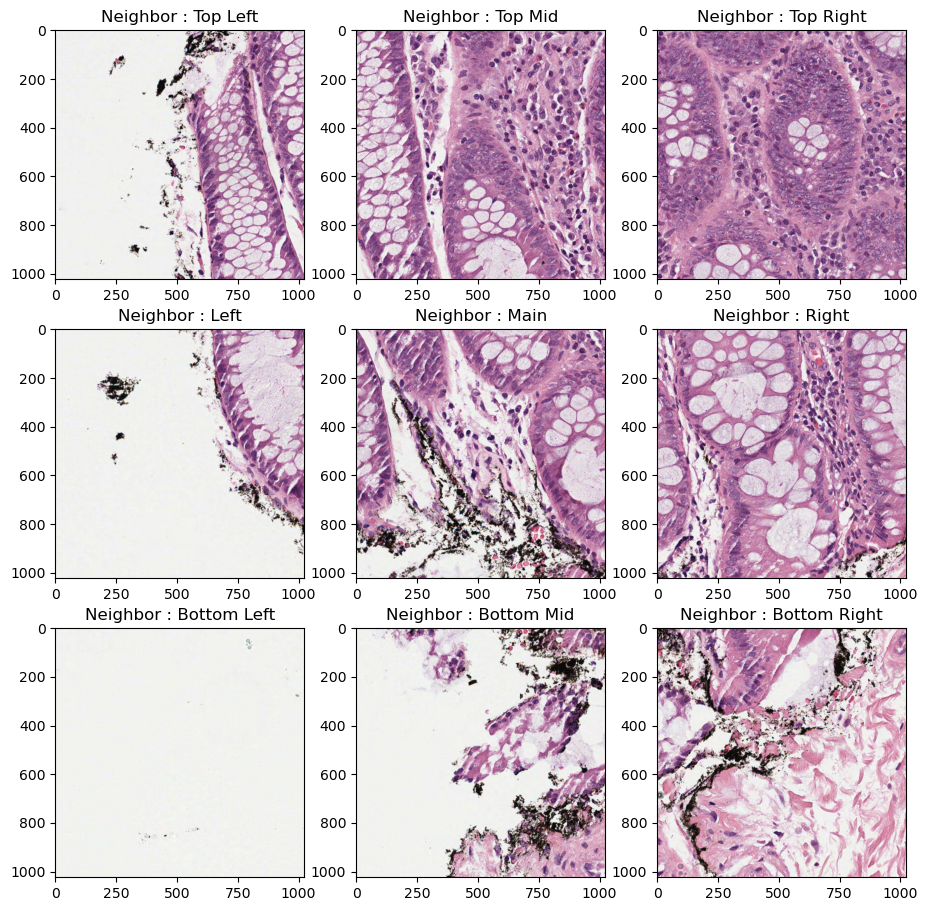

In [6]:
processor = ImageProcessing(images[1], 0.5, (1024,1024))
processor.optimal_level()
processor.display_neighbors_coordinates(10000, 10000)

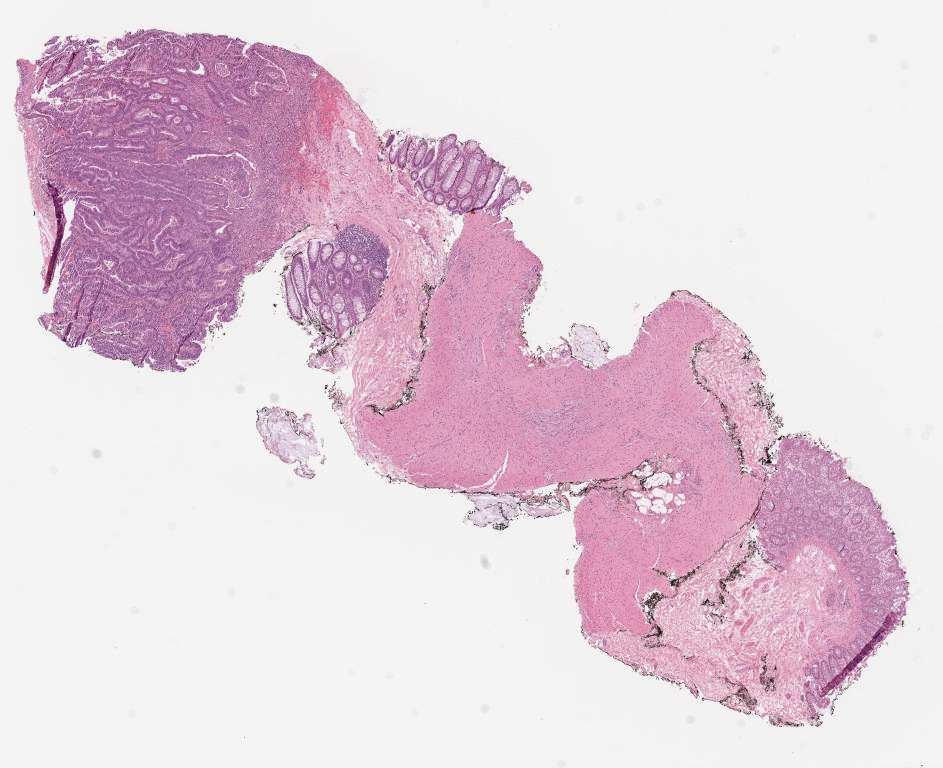

In [7]:
processor.image.associated_images["thumbnail"]

#### Image 3

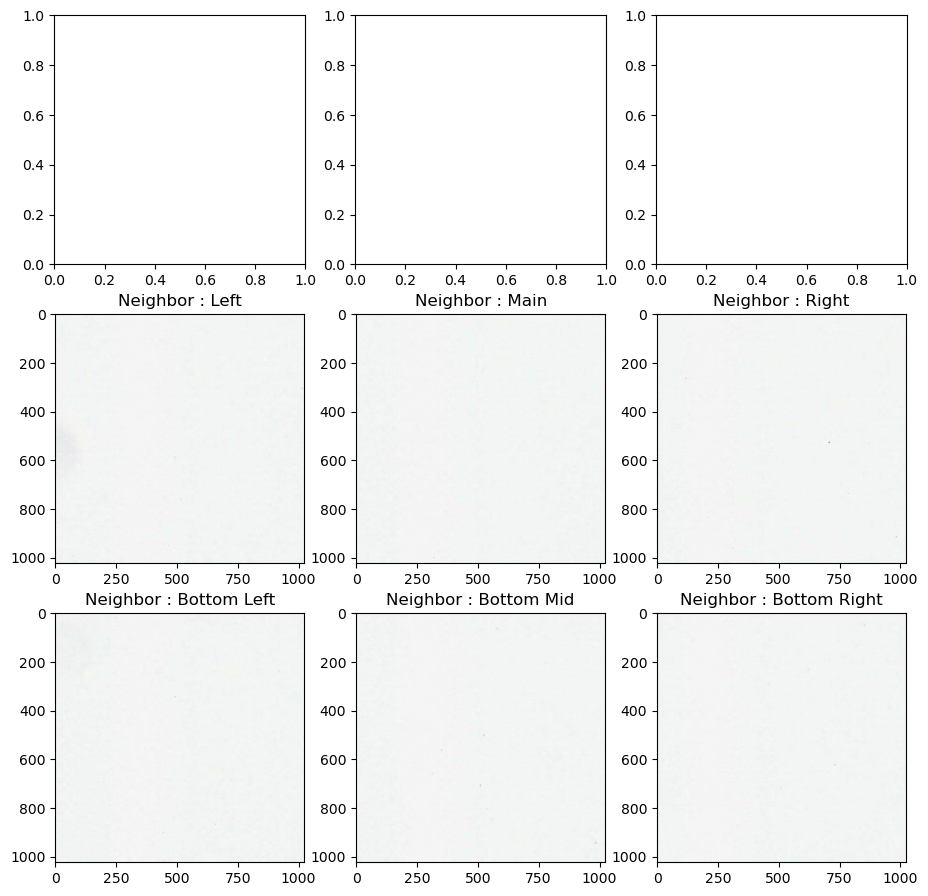

In [8]:
processor = ImageProcessing(images[2], 0.5, (1024,1024))
processor.optimal_level()
processor.display_neighbors_linear_index(20000)

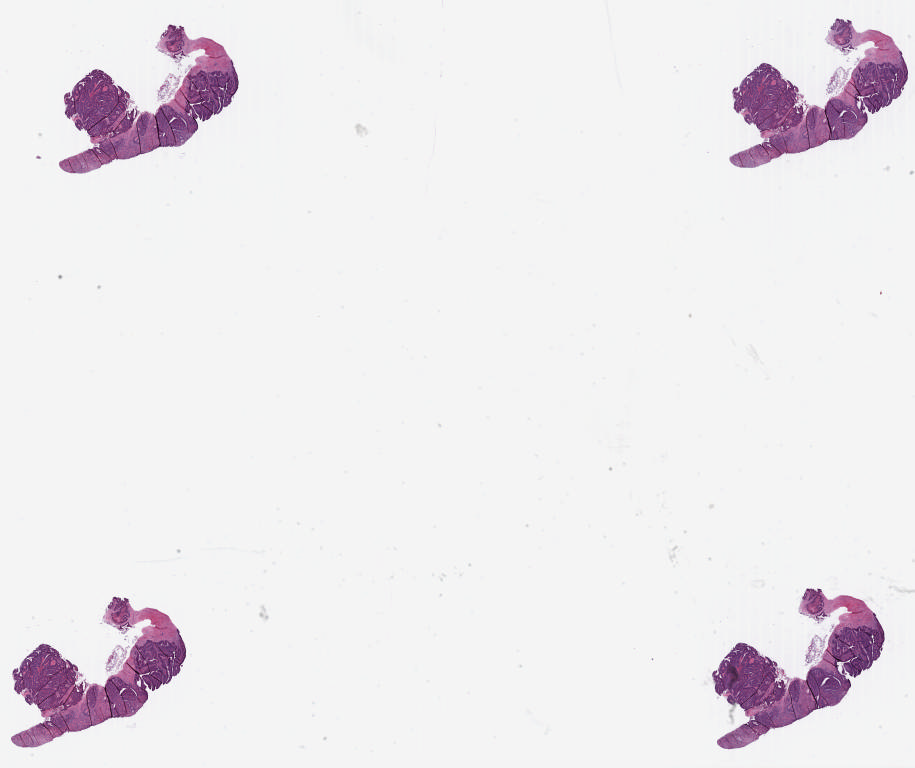

In [9]:
processor.image.associated_images["thumbnail"]

#### Image 4

In [10]:
processor = ImageProcessing(images[3], 0.5, (1024,1024))
processor.optimal_level()
regions, patch_information = processor.extract()

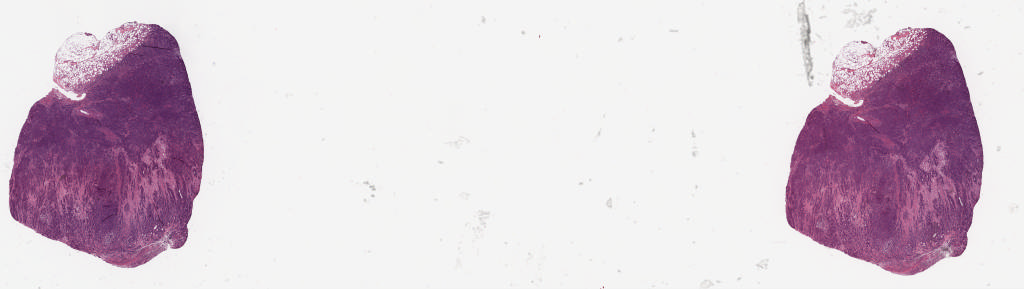

In [11]:
processor.image.associated_images["thumbnail"]